In [51]:
import pandas as pd
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [52]:
def wrangle(filepath, state = "Lagos"):
    df = pd.read_csv(filepath)
    
    #Subset to apartments in lagos
    df = df[df["state"] == state]
    
    #Drop '"state"' column because it has a low cardinality
    df.drop(columns = "state", inplace=True)
    
    #Check and remove outliers from the target
    df["price"].describe()
    low, high = df["price"].quantile([0.1, 0.9])
    
    #Subset price after removing the outliers
    df=df[df["price"].between(low,high)]

    #Drop highly correlated columns
    df.drop(columns = ["bathrooms"], inplace = True)

    return df

df = wrangle("nigeria_houses_data.csv", "Abuja")
df.head()

,bedrooms,toilets,parking_space,title,town,price
0,6.0,5.0,4.0,Detached Duplex,Mabushi,450000000.0
17,3.0,4.0,4.0,Detached Bungalow,Lokogoma District,37000000.0
23,5.0,7.0,6.0,Detached Duplex,Katampe,160000000.0
34,5.0,6.0,6.0,Detached Duplex,Kaura,150000000.0
35,4.0,5.0,8.0,Detached Duplex,Galadimawa,70000000.0


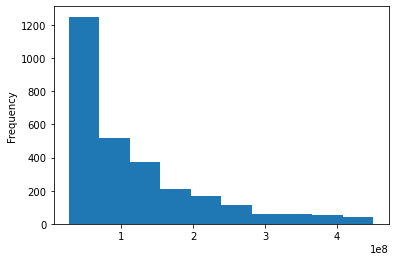

In [53]:
#Visualize and check for outliers using a histogram
df["price"].plot(kind = "hist");

In [54]:
#Check correlation
corr = df.select_dtypes("number").drop(columns = ["price"]).corr()
corr

,bedrooms,toilets,parking_space
bedrooms,1.000000,0.620737,0.037383
toilets,0.620737,1.000000,0.070095
parking_space,0.037383,0.070095,1.000000


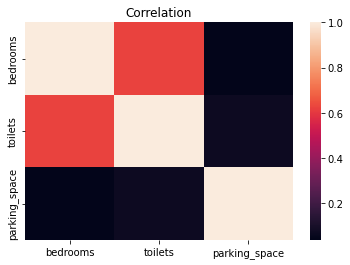

In [55]:
#Visualize correlation
sns.heatmap(corr)
plt.title("Correlation");

In [56]:
#Vertical Split
target = "price"
X = df.drop(columns = target)
y = df[target]

In [57]:
#Perform train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42

)

#Create Cut-off and split values
# cut_off = int(len(y) * 0.2)
# X_train,y_train = X.iloc[:cut_off],y.iloc[:cut_off]
# X_test,y_test = X.iloc[cut_off:],y.iloc[cut_off:]


In [58]:
#Mean absolute error of baseline
mae_baseline = round(mean_absolute_error([y_train.mean()] * len(y_train), y_train),2)
mae_baseline

70134758.21

In [59]:
#Train model
imputer = SimpleImputer()
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['title', 'town'], use_cat_names=True)),
                ('ridge', Ridge())])

In [60]:
#Mean absolute error of training
mae_training = round(mean_absolute_error(y_train, model.predict(X_train)),2)
mae_training

43816115.71

In [61]:
#Mean absolute error of test
mae_test = round(mean_absolute_error(y_test, model.predict(X_test)),2)
mae_test

45820515.78

In [62]:
#Generate features and coefficients
features = model.named_steps["onehotencoder"].get_feature_names()
coeff = model.named_steps["ridge"].coef_


In [63]:
#Create a series of coefficients where the index is the features
feat_imp = pd.Series(coeff, index = features)

In [64]:
X_train.columns

Index(['bedrooms', 'toilets', 'parking_space', 'title', 'town'], dtype='object')

In [65]:
#Generate test predictions
test_pred = pd.Series(model.predict(X_test))
test_pred[:5]

0    5.338399e+07
1    1.400386e+08
2    2.149211e+08
3    1.396080e+08
4    1.406431e+08
dtype: float64

In [66]:
def make_prediction(bedrooms, toilets, parking_space, title, town):
    data = {
        "bedrooms" : bedrooms,
        "toilets" : toilets,
        "parking_space" : parking_space,
        "title" : title,
        "town" : town
    }
    df = pd.DataFrame(data, index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted house price: #{prediction}"

In [67]:
make_prediction(2, 3, 4, "Detached Bungalow", "Lekki")

'Predicted house price: #51292790.26'

In [68]:
interact(
    make_prediction,
    bedrooms = IntSlider(
        min=X_train["bedrooms"].min(),
        max=X_train["bedrooms"].max(),
        value=X_train["bedrooms"].mean(),
    ),
    toilets = IntSlider(
        min=X_train["toilets"].min(),
        max=X_train["toilets"].max(),
        step=1,
        value=X_train["toilets"].mean(),
    ),
    parking_space = IntSlider(
        min=X_train["parking_space"].min(),
        max=X_train["parking_space"].max(),
        step=1,
        value=X_train["parking_space"].mean(),
    ),
    title = Dropdown(options=sorted(X_train["title"].unique())),
    town = Dropdown(options=sorted(X_train["town"].unique())),
);

interactive(children=(IntSlider(value=4, description='bedrooms', max=9, min=1), IntSlider(value=5, description…